# Soil Water Volume Content

In [1]:
%matplotlib inline
import sys

import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
import pickle as pickle
from sklearn import linear_model
import numpy.ma as ma
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing

import scipy as sp
import pandas as pd

import time

from copy import copy 

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# OS interaction
import os
import sys
import cftime

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

import matplotlib.colors as mcolors

import glob
import dask
import dask.bag as db

from scipy import interpolate

import statsmodels.stats.multitest as multitest

from matplotlib.gridspec import GridSpec
from cartopy.crs import EqualEarth, PlateCarree

# Set Path to ERA5 data and variables to choose

In [2]:
era5_path = '/glade/campaign/collections/rda/data/ds633.0/'

In [3]:
varlistnames = ['swvl1 0-7','swvl2 7-28','swvl3 28-100','swvl4 100-289']
varlist = ['swvl1', 'swvl2', 'swvl3', 'swvl4']

In [4]:
ds_list = []

for var in varlist:
    print(var)
    
    files = glob.glob(era5_path + 'e5.oper.an.sfc/' + #'e5.oper.fc.sfc.accumu/' +
                      '200?06' + '/*'+var+'*.nc')
    files.sort
    
    # print(files)
    
    ds_temp = xr.open_mfdataset(files)
    
    ds_list.append(ds_temp)
    
ds = xr.merge(ds_list)
    

swvl1
swvl2
swvl3
swvl4


In [5]:
print(list(ds.variables))

['SWVL1', 'latitude', 'longitude', 'time', 'utc_date', 'SWVL2', 'SWVL3', 'SWVL4']


# Inspect our dataset and see what's inside

In [6]:
ds

<xarray.Dataset>
Dimensions:    (time: 7200, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2000-06-01 ... 2009-06-30T23:00:00
Data variables:
    SWVL1      (time, latitude, longitude) float32 dask.array<chunksize=(720, 721, 1440), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(720,), meta=np.ndarray>
    SWVL2      (time, latitude, longitude) float32 dask.array<chunksize=(720, 721, 1440), meta=np.ndarray>
    SWVL3      (time, latitude, longitude) float32 dask.array<chunksize=(720, 721, 1440), meta=np.ndarray>
    SWVL4      (time, latitude, longitude) float32 dask.array<chunksize=(720, 721, 1440), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.3
    CONVERSION_PLATFORM:  Linux r1i4n2 4.12.14-94.41-default #1 SMP Wed Oct 3...
    CONVERSION_DATE:      Fri Jul 26 20:37:37 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Jul 26 20:37:53 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

# Subset the data for the southwest region

In [5]:
ds_sw = ds.sel(latitude=slice(45, 20), longitude=slice(238, 264), drop=True)

In [8]:
ds_sw

<xarray.Dataset>
Dimensions:    (time: 7200, latitude: 101, longitude: 105)
Coordinates:
  * latitude   (latitude) float64 45.0 44.75 44.5 44.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 238.0 238.2 238.5 238.8 ... 263.5 263.8 264.0
  * time       (time) datetime64[ns] 2000-06-01 ... 2009-06-30T23:00:00
Data variables:
    SWVL1      (time, latitude, longitude) float32 dask.array<chunksize=(720, 101, 105), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(720,), meta=np.ndarray>
    SWVL2      (time, latitude, longitude) float32 dask.array<chunksize=(720, 101, 105), meta=np.ndarray>
    SWVL3      (time, latitude, longitude) float32 dask.array<chunksize=(720, 101, 105), meta=np.ndarray>
    SWVL4      (time, latitude, longitude) float32 dask.array<chunksize=(720, 101, 105), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.3
    CONVERSION_PLATFORM:  Linux r1i4n2 4.12.14-94.41-default #1 SMP Wed Oct 3...
    CONVERSION_DATE:      Fri Jul 26 20:37:37 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Jul 26 20:37:53 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

# Load the data

In [6]:
tic = time.perf_counter()

ds_sw.load()

toc = time.perf_counter()

print(f"Time to load: {toc - tic:0.4f} seconds")

Time to load: 106.2916 seconds


# Plot 2-D map of first time slice 1st Var

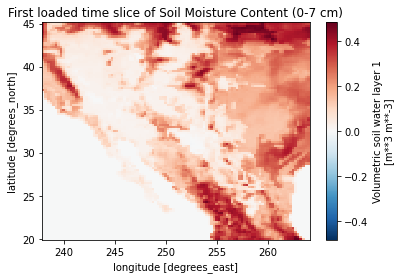

In [10]:
# ds_sw.SLHF.isel(forecast_hour=0,forecast_initial_time=0).plot()
ds_sw.SWVL1.isel(time=0).plot()

# 
plt.title('First loaded time slice of Soil Moisture Content (0-7 cm)')
plt.show()
plt.close()


# Plot 2-D map of first time slice 2nd Var

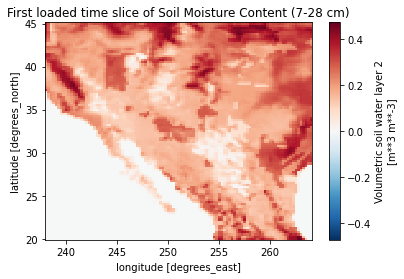

In [11]:
ds_sw.SWVL2.isel(time=0).plot()

# 
plt.title('First loaded time slice of Soil Moisture Content (7-28 cm)')
plt.show()
plt.close()


# Plot just the days in June

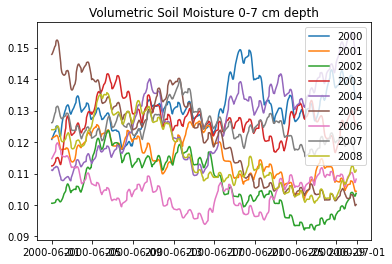

In [13]:
# get just the days of june to make the x-axis
june_days = ds_sw.where(ds_sw['time'].dt.year.isin([2000]), drop=True).time

for year in range(2000, 2009):
    
    ds_year = ds_sw.where(ds_sw['time'].dt.year.isin([year]), drop=True)
    plt.plot(june_days, ds_year.SWVL1.mean(['latitude', 'longitude']), label=year)

plt.title('Volumetric Soil Moisture 0-7 cm depth')
plt.legend()
plt.show()
plt.close()


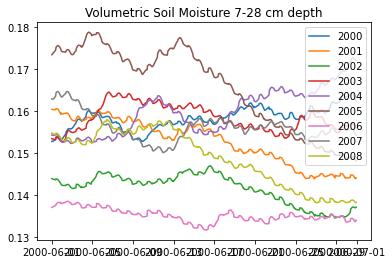

In [14]:
# get just the days of june to make the x-axis
june_days = ds_sw.where(ds_sw['time'].dt.year.isin([2000]), drop=True).time

for year in range(2000, 2009):
    
    ds_year = ds_sw.where(ds_sw['time'].dt.year.isin([year]), drop=True)
    plt.plot(june_days, ds_year.SWVL2.mean(['latitude', 'longitude']), label=year)

plt.title('Volumetric Soil Moisture 7-28 cm depth')

plt.legend()
plt.show()
plt.close()


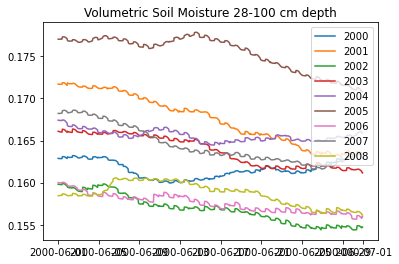

In [15]:
# get just the days of june to make the x-axis
june_days = ds_sw.where(ds_sw['time'].dt.year.isin([2000]), drop=True).time

for year in range(2000,2009):
    
    ds_year = ds_sw.where(ds_sw['time'].dt.year.isin([year]), drop=True)
    plt.plot(june_days, ds_year.SWVL3.mean(['latitude', 'longitude']), label=year)

plt.title('Volumetric Soil Moisture 28-100 cm depth')

plt.legend()
plt.show()
plt.close()


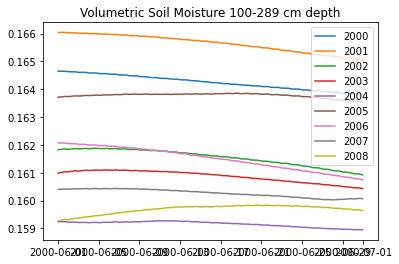

In [16]:
# get just the days of june to make the x-axis
june_days = ds_sw.where(ds_sw['time'].dt.year.isin([2000]), drop=True).time

for year in range(2000, 2009):
    
    ds_year = ds_sw.where(ds_sw['time'].dt.year.isin([year]), drop=True)
    plt.plot(june_days, ds_year.SWVL4.mean(['latitude', 'longitude']), label=year)

plt.title('Volumetric Soil Moisture 100-289 cm depth')
plt.legend()
plt.show()
plt.close()
